In [159]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [160]:
orders=pd.read_csv('datasets/data_orders.csv')
offers=pd.read_csv('datasets/data_offers.csv')
merged_data = pd.merge(orders, offers, on='order_gk', how='left')
merged_data = merged_data.drop_duplicates(subset='order_gk', keep='first')
merged_data.head()
len(merged_data)

10716

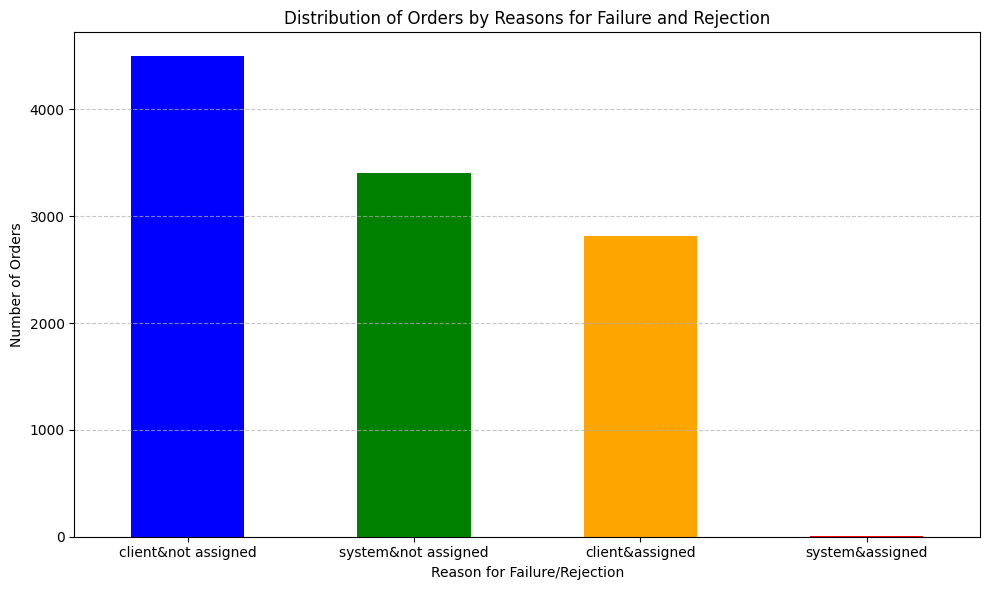

Cancelled by Client (Before Driver Assignment)    4496
Cancelled by System (Before Driver Assignment)    3406
Cancelled by Client (After Driver Assignment)     2811
Cancelled by System (After Driver Assignment)        3
Name: failure_reason, dtype: int64


In [161]:
merged_data['failure_reason'] = 'Success'
merged_data.loc[(merged_data['order_status_key'] == 4) & (merged_data['is_driver_assigned_key'] == 0), 'failure_reason'] = 'Cancelled by Client (Before Driver Assignment)'
merged_data.loc[(merged_data['order_status_key'] == 4) & (merged_data['is_driver_assigned_key'] == 1), 'failure_reason'] = 'Cancelled by Client (After Driver Assignment)'
merged_data.loc[(merged_data['order_status_key'] == 9) & (merged_data['is_driver_assigned_key'] == 0), 'failure_reason'] = 'Cancelled by System (Before Driver Assignment)'
merged_data.loc[(merged_data['order_status_key'] == 9) & (merged_data['is_driver_assigned_key'] == 1), 'failure_reason'] = 'Cancelled by System (After Driver Assignment)'

failure_counts = merged_data['failure_reason'].value_counts()

plt.figure(figsize=(10, 6))
failure_counts.plot(kind='bar', color=['blue', 'green', 'orange', 'red'])
plt.title('Distribution of Orders by Reasons for Failure and Rejection')
plt.xlabel('Reason for Failure/Rejection')
plt.ylabel('Number of Orders')
plt.xticks(ticks=[0, 1, 2, 3], labels=["client&not assigned", "system&not assigned","client&assigned","system&assigned"], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(failure_counts)


There are some patterns in the plot as follows:
* More orders are cancelled by customers than by the system
* More cancellation before driver assignment 
* Nearly none cancellations by system after assignment
<br>

Highest number of cancellation due to client before driver assignment

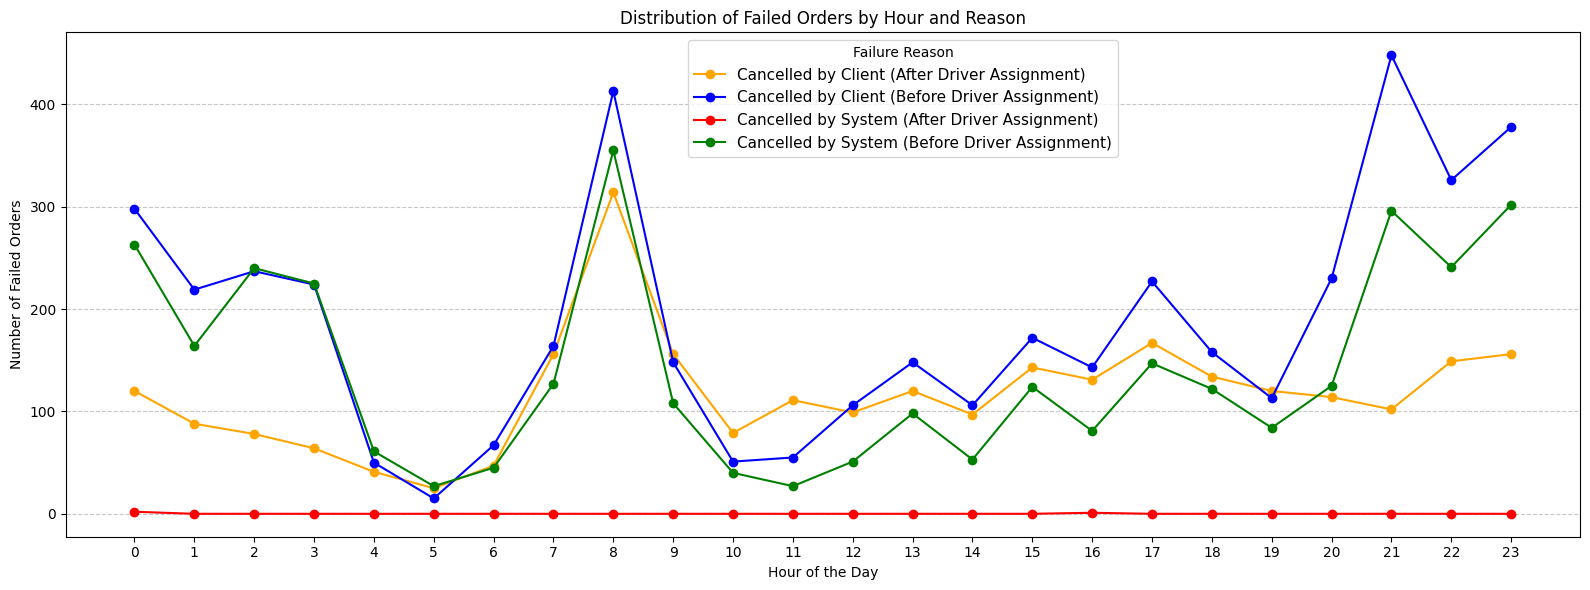

In [153]:
colors = ['orange', 'blue', 'red', 'green']

merged_data['order_datetime'] = pd.to_datetime(merged_data['order_datetime'])

merged_data['hour'] = merged_data['order_datetime'].dt.hour

failed_orders_by_hour = merged_data.groupby(['hour', 'failure_reason']).size().unstack(fill_value=0)

plt.figure(figsize=(16, 6))

for i, reason in enumerate(failed_orders_by_hour.columns):
    plt.plot(failed_orders_by_hour.index, failed_orders_by_hour[reason], marker='o', label=reason, color=colors[i])

plt.title('Distribution of Failed Orders by Hour and Reason')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Failed Orders')
plt.xticks(range(24))
plt.legend(title='Failure Reason', loc='upper right', fontsize=11, bbox_to_anchor=(0.7, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


* Btween 8:00 and 9:00 there's an abnormally high proportion(except for cancellation by system after assignment).
* There is a very high proportion of cancellations before assignment(by client & by system) after 21:00

The biggest fails appears at 8:00

8:00~9:00 is the morning rush hour, There may be no available driver nearby (canceled by system before driver assignment & Cancelled by Client Before assignment), or it'll take the driver too long to arrive and exceeds the passenger's budget. (Cancelled by Client After Driver Assignment)

After 9 o 'clock, most drivers may choose to go home to rest (canceled by system before driver assignment & Cancelled by Client Before assignment); There is also a certain percentage (Cancelled by Client After Driver Assignment), which may be due to the system noticing this and increasing the distance of the driver matching, but the customer is not willing to wait such a long time and try to use other software or other methods.


<Figure size 1200x600 with 0 Axes>

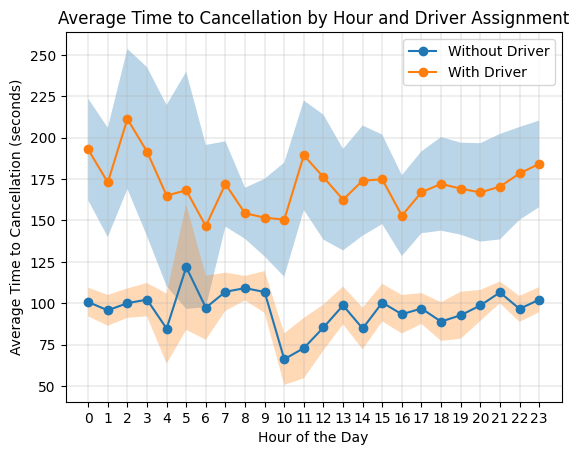

In [155]:
for assigned_key in merged_data['is_driver_assigned_key'].unique():
    subset = merged_data[merged_data['is_driver_assigned_key'] == assigned_key]
    Q1 = subset['cancellations_time_in_seconds'].quantile(0.25)
    Q3 = subset['cancellations_time_in_seconds'].quantile(0.75)
    IQR = Q3 - Q1
    merged_data = merged_data[~((merged_data['is_driver_assigned_key'] == assigned_key) &
                              ((merged_data['cancellations_time_in_seconds'] <= (Q1 - 1.5 * IQR)) |
                              (merged_data['cancellations_time_in_seconds'] >= (Q3 + 1.5 * IQR))))]

merged_data['hour'] = merged_data['order_datetime'].dt.hour

grouped_data = merged_data.groupby(['hour', 'is_driver_assigned_key'])['cancellations_time_in_seconds']
avg_cancellation_time = grouped_data.mean().unstack()
std_cancellation_time = grouped_data.std().unstack()
count_cancellation_time = grouped_data.count().unstack()
confidence_interval = 1.96 * (std_cancellation_time / np.sqrt(count_cancellation_time))

plt.figure(figsize=(12, 6))
avg_cancellation_time.plot(marker='o')
for assigned_key in merged_data['is_driver_assigned_key'].unique():
    lower_bound = avg_cancellation_time[assigned_key] - confidence_interval[assigned_key]
    upper_bound = avg_cancellation_time[assigned_key] + confidence_interval[assigned_key]
    plt.fill_between(avg_cancellation_time.index, lower_bound, upper_bound, alpha=0.3)
plt.title('Average Time to Cancellation by Hour and Driver Assignment')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Time to Cancellation (seconds)')
plt.xticks(np.arange(24))
plt.grid(True, linewidth=0.3)  
plt.legend(['Without Driver', 'With Driver'])
plt.show()


* Fewer average time to cancellations overall when there are no drivers. When a driver is matched, the customer is more willing to wait.
* When no driver was matched, the variance of the wait time was smaller. Because there are many more factors that affect the situation that matches the driver, such as road conditions and distance (which affects arrival time), customer patience and urgency (which affects client decisions).

C:\Users\vjjh\AppData\Local\Temp\ipykernel_24256\4115196306.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assigned_orders['hour'] = assigned_orders['order_datetime'].dt.hour


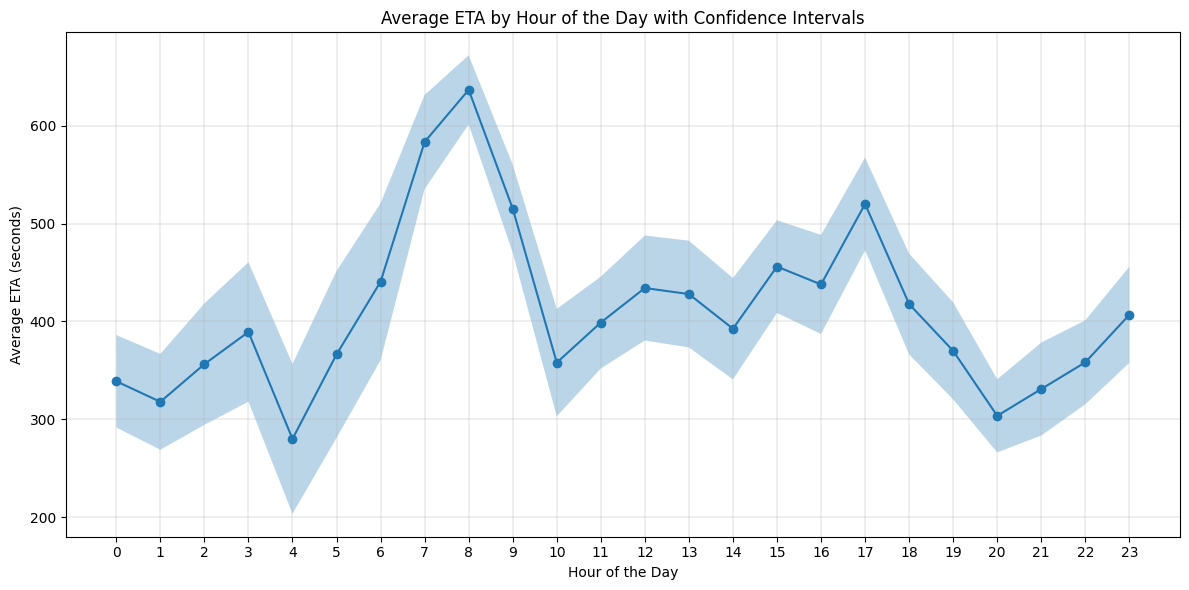

In [156]:
assigned_orders = merged_data[merged_data['is_driver_assigned_key'] == 1]

assigned_orders['hour'] = assigned_orders['order_datetime'].dt.hour

avg_eta_by_hour = assigned_orders.groupby('hour')['m_order_eta'].mean()
std_eta_by_hour = assigned_orders.groupby('hour')['m_order_eta'].std()
count_eta_by_hour = assigned_orders.groupby('hour')['m_order_eta'].count()
confidence_interval = 1.96 * (std_eta_by_hour / np.sqrt(count_eta_by_hour))

plt.figure(figsize=(12, 6))
avg_eta_by_hour.plot(marker='o')
lower_bound = avg_eta_by_hour - confidence_interval
upper_bound = avg_eta_by_hour + confidence_interval
plt.fill_between(avg_eta_by_hour.index, lower_bound, upper_bound, alpha=0.3)
plt.title('Average ETA by Hour of the Day with Confidence Intervals')
plt.xlabel('Hour of the Day')
plt.ylabel('Average ETA (seconds)')
plt.xticks(range(24))
plt.grid(True, linewidth=0.3)
plt.tight_layout()
plt.show()


* The average arrival time during peak hours is longer, and the average arrival time has a certain positive correlation with the number of cancellations, because the influencing factors for both are similar (including road conditions, the number of current taxi customers and drivers, etc.).

* Unlike the number of cancellations, there are more cancellations late at night (after 9 o 'clock), but the arrival time is shorter, possibly because late at night, although there are fewer drivers and the distance may be longer, the road is in good condition (fewer vehicles).

In [163]:
import folium
import h3
from collections import defaultdict

hexagon_orders_count = defaultdict(int)

for index, row in merged_data.iterrows():
    lat = row['origin_latitude']
    lon = row['origin_longitude']
    hex_id = h3.geo_to_h3(lat, lon, 8)
    hexagon_orders_count[hex_id] += 1

sorted_hexagons = sorted(hexagon_orders_count.items(), key=lambda x: x[1], reverse=True)

total_orders = merged_data.shape[0]
cumulative_orders = 0
top_hexagons = []
for hex_id, order_count in sorted_hexagons:
    cumulative_orders += order_count
    top_hexagons.append(hex_id)
    if cumulative_orders >= total_orders * 0.8:
        break

hexagon_fail_count = defaultdict(int)

for index, row in merged_data.iterrows():
    lat = row['origin_latitude']
    lon = row['origin_longitude']
    hex_id = h3.geo_to_h3(lat, lon, 8)
    if hex_id in top_hexagons and row['order_status_key'] in [4, 9]:
        hexagon_fail_count[hex_id] += 1

mean_lat = merged_data['origin_latitude'].mean()
mean_lon = merged_data['origin_longitude'].mean()
mymap = folium.Map(location=[mean_lat, mean_lon], zoom_start=10)

colormap = folium.LinearColormap(colors=['green', 'yellow', 'red'], vmin=0, vmax=max(hexagon_fail_count.values()), caption='Fail Count')

for hex_id, fail_count in hexagon_fail_count.items():
    lat, lon = h3.h3_to_geo(hex_id)
    vertices = h3.h3_to_geo_boundary(hex_id)
    color = colormap(fail_count)
    folium.Polygon(locations=vertices, color=color, fill_color=color, fill_opacity=0.5, popup=f'Fail Count: {fail_count}').add_to(mymap)

colormap.add_to(mymap)

mymap.save('hexagon_map.html')

mymap

There are 24 hexes in total, and the hexes with the highest number of cancellations containing a train station. In addition, other hexagons with a large number of cancellations contain some campus.